<a href="https://colab.research.google.com/github/data2450/transfer-learning-on-rock-paper-scissor-data/blob/main/transfer_learning_on_rock_paper_scissor_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep convolutional neural network models may take days or even weeks to train on very large datasets.

A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.

Transfer learning involves using models trained on one problem as a starting point on a related problem.
Transfer learning is flexible, allowing the use of pre-trained models directly, as feature extraction preprocessing, and integrated into entirely new models.
Keras provides convenient access to many top performing models on the ImageNet image recognition tasks such as VGG, Inception, and ResNet.

In [22]:
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import os
import numpy as np

import tensorflow_datasets as tfds


In [23]:
datasets,info=tfds.load(name='rock_paper_scissors',with_info=True,as_supervised=True,split=['train','test'])

In [24]:
info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


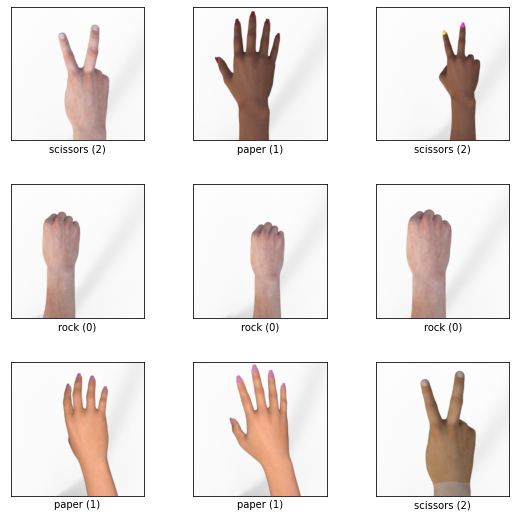

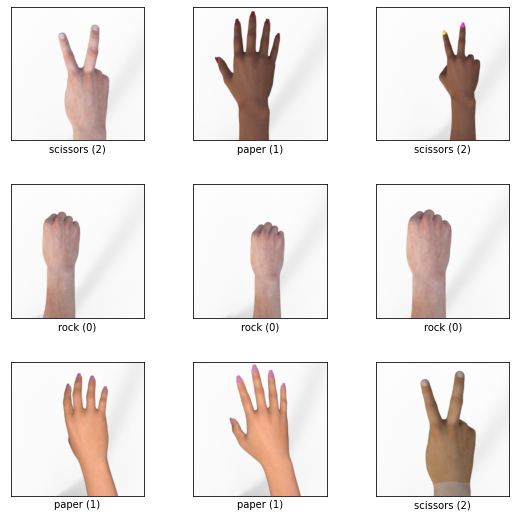

In [25]:
train, info_train = tfds.load(name='rock_paper_scissors', with_info=True, split='test')
tfds.show_examples(info_train,train)

In [26]:
#taking the train and test and combaining them to a newdataframe
dataset=datasets[0].concatenate(datasets[1])
dataset=dataset.shuffle(3000)

In [27]:
#validation takes 600 test skips that 600 take 400,train skip that 400 and take the remaining
rsp_val=dataset.take(600)
rsp_test_temp=dataset.skip(600)
rsp_test=rsp_test_temp.take(400)
rsp_train=rsp_test_temp.skip(400)

#

In [28]:
len(list(rsp_train))

1892

In [29]:
# scaling the images
def scale(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255.0

  return tf.image.resize(image,[224,224]), tf.one_hot(label, 3)

In [30]:
def get_dataset(batch_size=64):
  train_dataset_scaled = rsp_train.map(scale).shuffle(1900).batch(batch_size)
  test_dataset_scaled =  rsp_test.map(scale).batch(batch_size)
  val_dataset_scaled =  rsp_val.map(scale).batch(batch_size)
  return train_dataset_scaled, test_dataset_scaled, val_dataset_scaled

In [31]:
train_dataset, test_dataset, val_dataset = get_dataset()
train_dataset.cache()
val_dataset.cache()

<CacheDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>

In [32]:
feature_extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [33]:
feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape=(224,224,3))

In [34]:
feature_extractor_layer.trainable = False

In [36]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(3,activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [37]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [38]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [39]:
train_dataset

<BatchDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>

In [40]:
batch_stats_callback = CollectBatchStats()

history = model.fit_generator(train_dataset, epochs=2, validation_data=val_dataset,
                              callbacks = [batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/2
30/30 [==============================] - 81s 3s/step - loss: 0.6957 - acc: 0.8889 - val_loss: 0.6773 - val_acc: 0.9550
Epoch 2/2
30/30 [==============================] - 80s 3s/step - loss: 0.6626 - acc: 0.9444 - val_loss: 0.6071 - val_acc: 0.9800


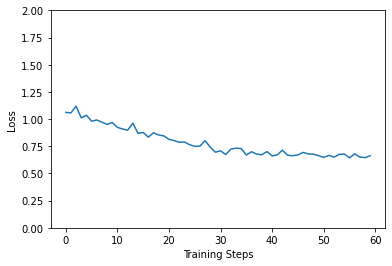

In [41]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

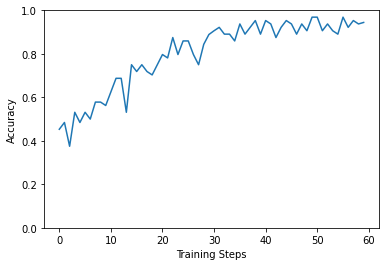

In [42]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [43]:
result=model.evaluate(test_dataset)

7/7 [==============================] - 11s 2s/step - loss: 0.6006 - acc: 0.9850


[[0.01063765 0.01813968 0.9712227 ]]


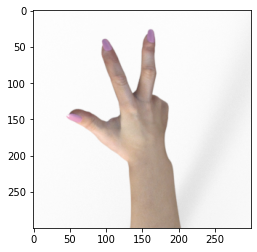

Actual Label: scissors
Predicted Label: scissors
[[0.00620921 0.02372442 0.97006637]]


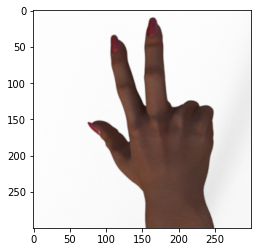

Actual Label: scissors
Predicted Label: scissors
[[0.16849245 0.82838356 0.00312399]]


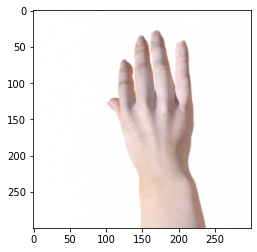

Actual Label: paper
Predicted Label: paper
[[0.00278785 0.01728003 0.9799321 ]]


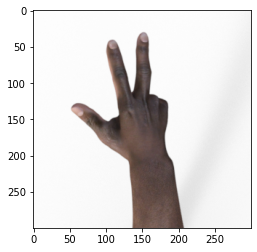

Actual Label: scissors
Predicted Label: scissors
[[0.01900369 0.9715999  0.00939642]]


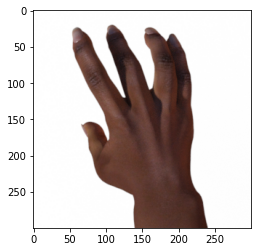

Actual Label: paper
Predicted Label: paper
[[0.01052115 0.9825011  0.00697779]]


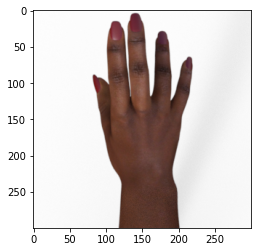

Actual Label: paper
Predicted Label: paper
[[0.99278486 0.00463675 0.00257834]]


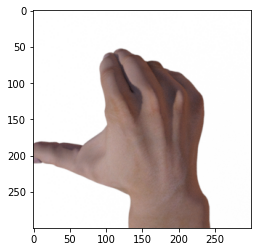

Actual Label: rock
Predicted Label: rock
[[0.9840306  0.01122523 0.00474421]]


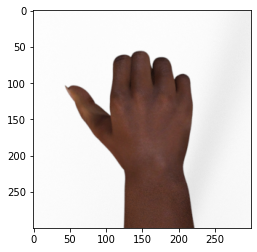

Actual Label: rock
Predicted Label: rock
[[0.8298834  0.15554    0.01457663]]


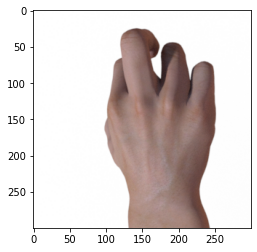

Actual Label: rock
Predicted Label: rock
[[0.01949225 0.97208774 0.00841993]]


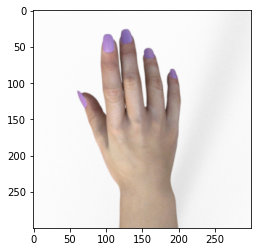

Actual Label: paper
Predicted Label: paper


In [44]:
for test_sample in rsp_test.take(10):  
  image, label = test_sample[0], test_sample[1]
  image_scaled, label_arr= scale(test_sample[0], test_sample[1])
  image_scaled = np.expand_dims(image_scaled, axis=0)   

  img = tf.keras.preprocessing.image.img_to_array(image)                    
  pred=model.predict(image_scaled)
  print(pred)
  plt.figure()
  plt.imshow(image)
  plt.show()
  print("Actual Label: %s" % info.features["label"].names[label.numpy()])
  print("Predicted Label: %s" % info.features["label"].names[np.argmax(pred)])

In [45]:
#test target outputs
np.argmax(model.predict(test_dataset),axis=1)

array([0, 2, 1, 0, 2, 2, 2, 1, 1, 0, 0, 2, 0, 0, 0, 2, 1, 2, 2, 2, 1, 0,
       1, 2, 0, 0, 0, 0, 0, 1, 1, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 1, 1,
       0, 1, 0, 2, 0, 2, 2, 1, 2, 1, 0, 2, 2, 1, 0, 2, 0, 2, 0, 1, 2, 0,
       2, 2, 0, 0, 1, 0, 1, 0, 2, 1, 0, 0, 1, 2, 2, 1, 1, 1, 0, 2, 0, 1,
       0, 0, 1, 2, 2, 0, 1, 0, 1, 1, 0, 2, 2, 2, 1, 0, 0, 0, 1, 1, 1, 0,
       2, 1, 0, 2, 2, 2, 1, 2, 2, 0, 1, 1, 2, 1, 0, 0, 2, 0, 2, 0, 1, 0,
       1, 2, 2, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 2, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 2, 0, 1, 0, 1, 0, 1, 2, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 0, 2, 2, 0, 2, 0, 0,
       2, 0, 1, 2, 1, 0, 0, 0, 2, 1, 0, 2, 2, 1, 1, 1, 0, 2, 0, 1, 1, 0,
       1, 1, 0, 2, 1, 2, 1, 1, 1, 0, 0, 2, 1, 1, 2, 1, 1, 0, 0, 2, 1, 0,
       0, 2, 1, 0, 2, 0, 2, 2, 0, 2, 1, 0, 2, 0, 2, 1, 0, 2, 0, 1, 2, 2,
       2, 0, 1, 1, 0, 2, 0, 2, 1, 2, 1, 1, 1, 0, 0, 2, 1, 1, 2, 1, 2, 2,
       0, 2, 2, 0, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1,

In [46]:
for f0,f1 in rsp_test.map(scale).batch(400):
  y=np.argmax(f1, axis=1)
  y_pred=np.argmax(model.predict(f0),axis=1)
  print(tf.math.confusion_matrix(labels=y, predictions=y_pred, num_classes=3))

tf.Tensor(
[[119   0   0]
 [  5 132   0]
 [  0   0 144]], shape=(3, 3), dtype=int32)


In [47]:
model.save('./models/', save_format='tf')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


In [48]:
!ls -alrt

total 24
drwxr-xr-x 1 root root 4096 Nov  6 17:30 sample_data
drwxr-xr-x 1 root root 4096 Nov  6 17:30 .config
drwxr-xr-x 1 root root 4096 Nov 13 05:26 ..
drwx------ 4 root root 4096 Nov 13 05:37 drive
drwxr-xr-x 1 root root 4096 Nov 13 08:48 .
drwxr-xr-x 4 root root 4096 Nov 13 08:48 models


In [49]:
ls models

assets/  saved_model.pb  variables/


In [50]:
ls -alrt models

total 2056
drwxr-xr-x 1 root root    4096 Nov 13 08:48 ../
drwxr-xr-x 2 root root    4096 Nov 13 08:48 variables/
drwxr-xr-x 2 root root    4096 Nov 13 08:48 assets/
-rw-r--r-- 1 root root 2085492 Nov 13 08:48 saved_model.pb
drwxr-xr-x 4 root root    4096 Nov 13 08:48 ./


In [51]:
loaded_model = tf.keras.models.load_model('models')

[[0.9551459  0.04268327 0.00217083]]


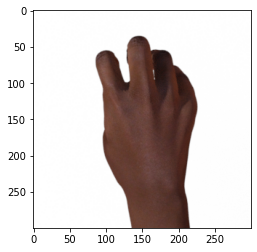

Actual Label: rock
Predicted Label: rock
[[0.9198998  0.04834271 0.03175745]]


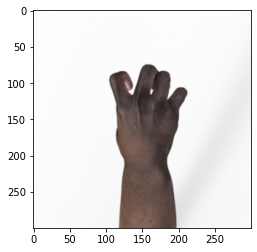

Actual Label: rock
Predicted Label: rock
[[0.01870867 0.48787224 0.49341908]]


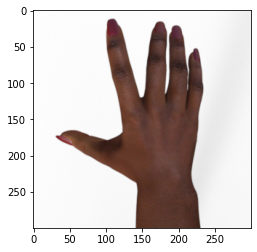

Actual Label: paper
Predicted Label: scissors
[[9.9825054e-01 1.7250993e-03 2.4306717e-05]]


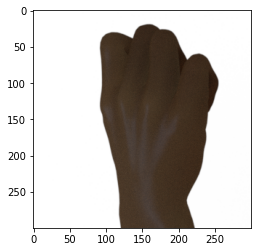

Actual Label: rock
Predicted Label: rock
[[9.9824357e-01 1.7140335e-03 4.2401436e-05]]


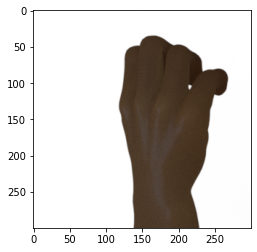

Actual Label: rock
Predicted Label: rock
[[0.00277392 0.9655577  0.03166842]]


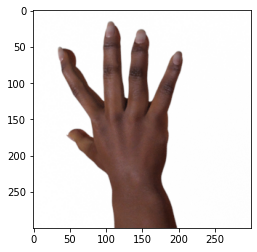

Actual Label: paper
Predicted Label: paper
[[0.00323728 0.99064845 0.00611417]]


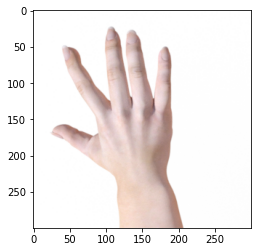

Actual Label: paper
Predicted Label: paper
[[0.09049807 0.64755005 0.26195186]]


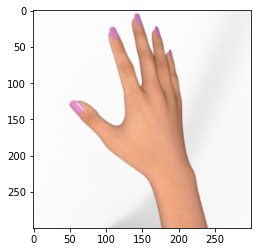

Actual Label: paper
Predicted Label: paper
[[0.03624047 0.9553826  0.00837683]]


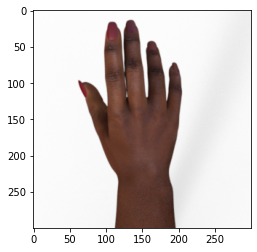

Actual Label: paper
Predicted Label: paper
[[0.99608696 0.00186904 0.00204404]]


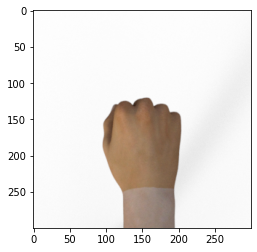

Actual Label: rock
Predicted Label: rock


In [52]:
for test_sample in rsp_test.take(10):  
  image, label = test_sample[0], test_sample[1]
  image_scaled, label_arr= scale(test_sample[0], test_sample[1])
  image_scaled = np.expand_dims(image_scaled, axis=0)   

  img = tf.keras.preprocessing.image.img_to_array(image)                    
  pred=loaded_model.predict(image_scaled)
  print(pred)
  plt.figure()
  plt.imshow(image)
  plt.show()
  print("Actual Label: %s" % info.features["label"].names[label.numpy()])
  print("Predicted Label: %s" % info.features["label"].names[np.argmax(pred)])